In [2]:
cd "nilm data\all"

D:\jjenko\nilm data\all


In [3]:
from nilmtk import DataSet
from nilmtk.utils import print_dict
from matplotlib import rcParams
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import nilmtk
from nilmtk import DataSet, MeterGroup
import h5py

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from pyts.image import GramianAngularField



plt.style.use('ggplot')
rcParams['figure.figsize'] = (12, 10)
plt.figure(figsize=(10,30))

dataset = DataSet('redd.h5')
dataset.set_window(start='2010-3-15T1127',end='2013-7-20T1200')


<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 80 from C header, got 88 from PyObject


<Figure size 720x2160 with 0 Axes>

C:\Users\jjenko\anaconda3\envs\nilmtk-env\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


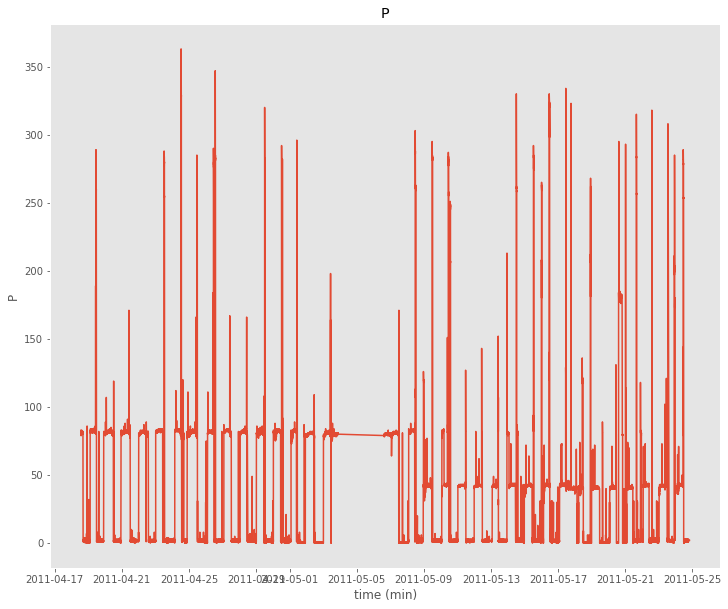

In [4]:
elec = dataset.buildings[1].elec
fridge = elec["light"]
fridge.available_columns()
df = next(fridge.load(physical_quantity='power'))

fig, ax = plt.subplots()
ax.plot(df.fillna(0))
ax.set(xlabel='time (min)', ylabel='P', title='P')
ax.grid()

#df.power.active[1900:1950]

In [23]:
elec.appliances

[Appliance(type='unknown', instance=2),
 Appliance(type='light', instance=2),
 Appliance(type='sockets', instance=1),
 Appliance(type='sockets', instance=4),
 Appliance(type='electric oven', instance=1),
 Appliance(type='unknown', instance=1),
 Appliance(type='light', instance=1),
 Appliance(type='dish washer', instance=1),
 Appliance(type='electric stove', instance=1),
 Appliance(type='sockets', instance=3),
 Appliance(type='light', instance=3),
 Appliance(type='washer dryer', instance=1),
 Appliance(type='electric space heater', instance=1),
 Appliance(type='fridge', instance=1),
 Appliance(type='sockets', instance=2),
 Appliance(type='microwave', instance=1)]

In [4]:
values = df.power.values
allZeros = np.all(values==0)
print(allZeros)

False


In [5]:
def create_file(dataset_name,step_in_mins,max_dataset_size,img_size,n_of_multi_dim_imgs,appliances):

    #cell is responsible for storing and handling with hdf5 data
    #if file does not exist create new one (M-n of months A-n of appliances)
    #file_name = "UKDALE_GAF_1h_12M10A300N"
    file_name =f"{dataset_name}""_"f"{step_in_mins}""m_"f"{img_size}""S"f"{n_of_multi_dim_imgs}""X_"f"{len(appliances)}""A"f"{max_dataset_size}""N" 

    #check if file exists
    try:
        file = h5py.File("D:/jjenko/nilm data/GAF_DS/"f"{file_name}"".hdf5","r")
        print("file exists!")
        file.close()

    except:
        print("creating new file! ...")
        file = h5py.File("D:/jjenko/nilm data/GAF_DS/"f"{file_name}"".hdf5", "w")


        group = file.create_group("classes")
        
        file.close()

    return file_name

def create_hdf5_group(group_name): #groups are appliances such as fridge or toaster

    file = h5py.File("D:/jjenko/nilm data/GAF_DS/"f"{file_name}"".hdf5", "a")
    dataset = file.create_group(f"{group_name}")
    file.close()


def store_single_hdf5(data, file_id, group_name): 
    """
    Stores single image to HDF5
    """     
    file = h5py.File("D:/jjenko/nilm data/GAF_DS/"f"{file_name}"".hdf5", "a")
    group = file[f"{group_name}"]
    
    try:
        group.create_dataset(f"{file_id}",np.shape(data),data = data)  
    except:
        del group[f"{file_id}"]
        group.create_dataset(f"{file_id}",np.shape(data),data = data)
        print("  replaced "f"{file_id}""!")
   
    file.close()

def store_many_hdf5(images,group_name,image_set_name,**kwargs):
    """
    Stores multiple images to HDF5
    **kwargs(force_del="yes" to replace existing db w/o prompt)
    """     
    #define some parameters
    num_images = len(images)
    force_del_flag = kwargs.get('force_del', None)# we need it, if "store many" is frequent
    
    label_flag = kwargs.get('labels', None)# we need it, if "store many" is frequent

    # read HDF5 file
    try:
        file = h5py.File("D:/jjenko/nilm data/GAF_DS/"f"{file_name}"".hdf5", "a")
    except:
        print("file not found!")
    
    
    # open specified group
    try:
        group = file[f"{group_name}"]
    except:
        #if if does not exist create it
        group = file.create_group(f"{group_name}")
        

    #check if ds already exists, then prompt user
    for name in group:
        if str(name) == str(image_set_name):
            if force_del_flag == "yes":
                print("  removed "f"{name}""!")   
                del group[name]
            else:
                print("Dataset '"f"{name}" "' already exists in " f"{file_name}""/"f"{group_name}")
                
                ans = input("Do you want to replace existing dataset? (y,n) Press enter to contine")
                    
                if ans == "y":
                    print("  removed "f"{name}""!")   
                    del group[name]
                else:
                    print("  quiting! ") 
                    raise

    # Create a dataset in the group       
    print("storing... images to store: "f"{num_images}")
    
    if label_flag == True:
        #save labels as integers. If sentence needed in case no labels are provided
        dataset = group.create_dataset(f"{image_set_name}", np.shape(images), h5py.h5t.H5T_STD_I8BE , data=images)
    else:
        dataset = group.create_dataset(f"{image_set_name}", np.shape(images), h5py.h5t.IEEE_F32LE , data=images)
    
    file.close()
    print("finshed. stored to " f"{file_name}""/"f"{group_name}""/"f"{image_set_name}")


def read_many_hdf5(group_name,image_set_name):
    """ 
    Reads image from HDF5.

    """
    images = []


    # Open the HDF5 file
    file = h5py.File("D:/jjenko/nilm data/GAF_DS/"f"{file_name}"".hdf5", "r+")

    images = np.array(file[f"{group_name}""/"f"{image_set_name}"])

    return images

In [6]:
#(debug)graph first portion of the seleted range
# n = 18
# ukdale.set_window(start=date_range[n],end=date_range[n+1])
# elec = ukdale.buildings[1].elec
# fridge = elec['fridge']
# fridge.available_columns()
# df = next(fridge.load(physical_quantity='power'))
# print(len(df))
# fig, ax = plt.subplots()
# ax.plot(df)
# ax.set(xlabel='time (min)', ylabel='P', title='P')
# ax.grid()

In [7]:
#next 3 cells generate GAFs on based on manual selecont of interval
#select time range and period
#was working for hourly data--
# step_in_hrs = 1
# date_range = pd.date_range("2013-1-10T0000", "2014-1-1T0000",freq=''+str(step_in_hrs)+'h')
#----------
#print(date_range)

In [9]:
#--PARAMTERS--#
#-step
step_in_mins = 13
date_range = pd.date_range("2010-1-10T0000", "2012-5-20T0000",freq=f'{step_in_mins}''T')

#-image
max_dataset_size = 1500 #max number of images per appliance
img_size = 100 # means img_size x img_size
n_of_multi_dim_imgs = 10 #change to 0 for normal images

#-samples
sample_period = 6 # cm be obtained from dataset.metadata["sample_period"] but it is inconsistent
percentage_of_missing_data_allowed = 0.8 # is necessary since sampling rate is inconsistent or samples are missing 

#-classes
#appliances for ukdale
#manualy_selected_appliances = ["computer monitor", "laptop computer", "television", "washer dryer", "microwave","boiler","toaster","kettle","fridge"]
#appliances for redd
manualy_selected_appliances = ["microwave","washer dryer", "dish washer","electric stove","electric oven","fridge","electric space heater","light"]

#main parameters - these are arrays that will hold all of the appended data
if n_of_multi_dim_imgs != 0:
    #use 4 dims
    gasf_stack_main = np.empty([0,n_of_multi_dim_imgs,img_size,img_size])
else:
    #use 3 dims
    gasf_stack_main = np.empty([0,img_size,img_size])

label_stack = np.empty(0)

appliance_weights = np.empty(0)
healthy_appliances = []

file_name = create_file(dataset.metadata["name"],step_in_mins,max_dataset_size,img_size,n_of_multi_dim_imgs,manualy_selected_appliances)

#the idea is to loop through all of the applianes and collect at least N of "max_dataset_size" images for each one
for appliance in manualy_selected_appliances:
    print("\n")
    print("starting "f"{appliance} ("+str(manualy_selected_appliances.index(appliance)+1)+"/"+str(len(manualy_selected_appliances))+"):")
    
    #define some of the paramteres mainly for creating stack of images
    N_of_dates = len(date_range)-2


    #check if user selected mutli dim images
    if n_of_multi_dim_imgs != 0:
        gasf_stack_tmp = np.empty([0,img_size,img_size])
        gasf_stack = np.empty([0,n_of_multi_dim_imgs,img_size,img_size])
        gadf_stack = np.empty([0,n_of_multi_dim_imgs,img_size,img_size])

    else:
        gasf_stack = np.empty([0,img_size,img_size])
        gadf_stack = np.empty([0,img_size,img_size])
   
    
    for building in dataset.buildings:

        #check if dataset size is larger than specified
        if gasf_stack.shape[0] >= max_dataset_size:
                    print("max DS size reached size of "f"{max_dataset_size}"", skipping!")   
                    break

        for interval in range(N_of_dates):

            print("\r",
                " data procesed: ",round(100*interval/(N_of_dates-1),2),"% ",
                " finished: ",round(100*gasf_stack.shape[0]/max_dataset_size,2),"% | ",
                end="")

            try:
                dataset.set_window(start=date_range[interval],end=date_range[interval+1])
            except:
                continue
            
            #try to read from dataset
            try:
                elec = dataset.buildings[building].elec
                appliance_data = elec[appliance]
                #appliance_data.available_columns()
                df = next(appliance_data.load(physical_quantity='power'))
            except:
                #uncomment fo debug
                #print("problem, no data for "+appliance+"!")
                continue

            #do some metric calcs in order to determine if selected window needs to be dropped
            metric = (60*step_in_mins)/sample_period #will adjust automaticly
            if len(df) < percentage_of_missing_data_allowed*metric:# -> manulay select %
                #uncomment for debug
                #if len(df) != 0:
                #print("skipped: "+str(date_range[interval])+" had only "+str(len(df))+" out of "+str(metric)+" points ("+str(int(100*(len(df))/metric))+"%)")
                continue 
            
            #check if all values in an array are equal to 0
            values = df.power.values
            All_zero = np.all(values==0)  
            All_ones = np.all(values==1)  
            All_equal = np.all(values==values[0])
            if All_zero == True or All_ones == True or All_equal == True:
                #print("skipped due all zero or all one")
                #if all values are 0 then skip
                continue

            #check if dataset size is larger than specified
            if gasf_stack.shape[0] >= max_dataset_size:
                print("max DS size reached size of "f"{max_dataset_size}"", skipping!")   
                break

            #do some reshaping to satisfy GAF library
            S = df.fillna(0).to_numpy().reshape(1,-1)
            Ssmall= S[0,0:S.size]
            S2d = np.reshape(Ssmall, (1, S.size))

            # Transform the time series into Gramian Angular Fields
            gasf = GramianAngularField(image_size=img_size, method='summation')
            X_gasf = gasf.fit_transform(S2d)
            #gadf = GramianAngularField(image_size=img_size, method='difference')
            #X_gadf = gadf.fit_transform(S2d)
            
            #part where we save converted images
            if len(gasf_stack.shape) == 4:

                #append as multi dimensonal images 
                if gasf_stack_tmp.shape[0] < n_of_multi_dim_imgs:
                    gasf_stack_tmp = np.append(gasf_stack_tmp,X_gasf,axis=0)
                else:
                    gasf_stack_tmp = gasf_stack_tmp[np.newaxis, ...] #add new axis for compatability
                    gasf_stack = np.append(gasf_stack,gasf_stack_tmp,axis=0)
                    label_stack = np.append(label_stack,int(f"{manualy_selected_appliances.index(appliance)}"))
                    gasf_stack_tmp = np.empty([0,img_size,img_size])
            else:
                #append as ordinary images
                gasf_stack = np.append(gasf_stack,X_gasf,axis=0)
                label_stack = np.append(label_stack,int(f"{manualy_selected_appliances.index(appliance)}"))
                
            
            

        print("finsihed building N",building)

    print("")
    print("number of images (per appliance) stacked: "f"{gasf_stack.shape[0]}"" out of all possible " f"{N_of_dates}" " ("f"{int(100*gasf_stack.shape[0]/N_of_dates)}""%)")
    
    
    gasf_stack_main = np.append(gasf_stack_main,gasf_stack,axis=0)

    if gasf_stack.shape[0] != 0:
        appliance_weights = np.append(appliance_weights,round(gasf_stack.shape[0]/max_dataset_size,2))
        healthy_appliances.append(appliance)
    else:
        print("no usefull data for "f"{appliance}"" found, skipping")

    print("finished "f"{appliance}")
    
    print("\n")

gasf_stack_main = gasf_stack_main[...,np.newaxis]
store_many_hdf5(gasf_stack_main,"data","gasf",force_del="yes")
store_many_hdf5(label_stack,"labels","gaf",force_del="yes",label=True)


asciiList = [n.encode("ascii", "ignore") for n in healthy_appliances]
store_single_hdf5(asciiList,"appliances","classes")
print("appliances stored: ", healthy_appliances)
store_single_hdf5(appliance_weights,"weights", "classes")
print("weights stored: ", appliance_weights)

creating new file! ...


starting microwave (1/8):
  data procesed:  40.73 %   finished:  43.67 % | finsihed building N 1
  data procesed:  40.61 %   finished:  89.33 % | finsihed building N 2
  data procesed:  38.23 %   finished:  100.0 % | max DS size reached size of 300, skipping!
finsihed building N 3
max DS size reached size of 300, skipping!

number of images (per appliance) stacked: 300 out of all possible 135802 (0%)
finished microwave




starting washer dryer (2/8):
finsihed building N 1
  data procesed:  40.59 %   finished:  44.0 % | finsihed building N 2
finsihed building N 3
  data procesed:  40.98 %   finished:  100.0 % | max DS size reached size of 300, skipping!
finsihed building N 4
max DS size reached size of 300, skipping!

number of images (per appliance) stacked: 300 out of all possible 135802 (0%)
finished washer dryer




starting dish washer (3/8):
  data procesed:  40.75 %   finished:  56.0 % | finsihed building N 1
  data procesed:  38.9 %   finished:  100.0 %

In [106]:
for building in dataset.buildings:
    print(building)
e

6

In [11]:
elec = dataset.buildings[building].elec
appliance_data = elec[appliance]
#appliance_data.available_columns()
df = next(appliance_data.load(physical_quantity='power'))

In [85]:
healthy_appliances  = []
print(healthy_appliances)

[]


In [ ]:
manualy_selected_appliances = ["computer monitor", "laptop computer", "televison", "washer dryer", "microwave","oven","boiler","toaster","kettle"]
usefull_appliances = manualy_selected_appliances.copy()
usefull_appliances.remove("televison")
print(usefull_appliances)

In [ ]:
# Show image to be saved
fig, ax = plt.subplots()
ax.imshow(gasf_stack[129], cmap='rainbow')
gasf_stack[129][50][50]

In [ ]:
#store images generated above
store_many_hdf5(gasf_stack,"fridge","gasf")

In [88]:
#retrieve stored images
ret_imgs = read_many_hdf5("data","gasf")
ret_labels =  read_many_hdf5("labels","gaf")
ret_appl = read_many_hdf5("classes","appliances")
ret_imgs.shape


(60, 300, 300, 1)

In [89]:
ret_appl

array([b'microwave', b'dish washer', b'electric stove', b'fridge',
       b'electric space heater', b'light', b'microwave', b'dish washer',
       b'electric stove', b'fridge', b'electric space heater', b'light'],
      dtype='|S21')

microwave


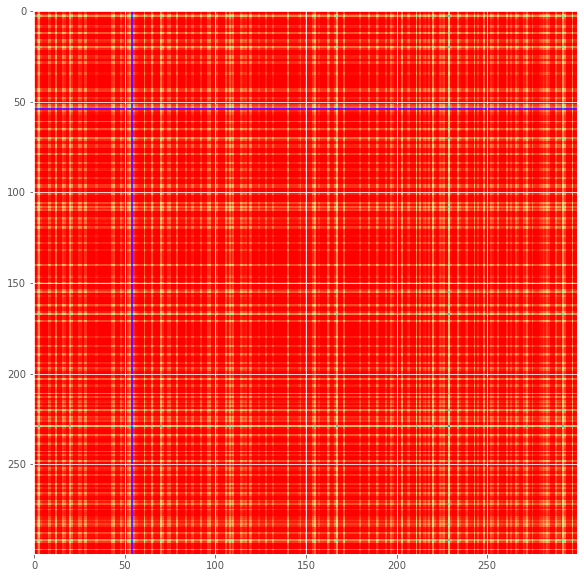

In [56]:
# Show retrieved image
someN = 1
fig, ax = plt.subplots()
ax.imshow(ret_imgs[someN,...,0], cmap='rainbow')
print(manualy_selected_appliances[int(ret_labels[someN])])
# ax.imshow(ret_img_stack[3,1], cmap='rainbow')
# ax.imshow(ret_img_stack[5,3], cmap='rainbow')



In [7]:
elec.appliances

[Appliance(type='light', instance=1),
 Appliance(type='sockets', instance=1),
 Appliance(type='electric space heater', instance=1),
 Appliance(type='unknown', instance=2),
 Appliance(type='sockets', instance=4),
 Appliance(type='microwave', instance=1),
 Appliance(type='light', instance=3),
 Appliance(type='washer dryer', instance=1),
 Appliance(type='electric stove', instance=1),
 Appliance(type='sockets', instance=3),
 Appliance(type='dish washer', instance=1),
 Appliance(type='light', instance=2),
 Appliance(type='fridge', instance=1),
 Appliance(type='unknown', instance=1),
 Appliance(type='electric oven', instance=1),
 Appliance(type='sockets', instance=2)]